In [100]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn import metrics
from statsmodels.tsa.api import Holt
import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import prepare

Split data (train/test) and resample by any period, except daily, and aggregate using the sum.\
Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:\
Simple Average\
Moving Average\
Holt's Linear Trend Model\
Based on previous year/month/etc., this is up to you.

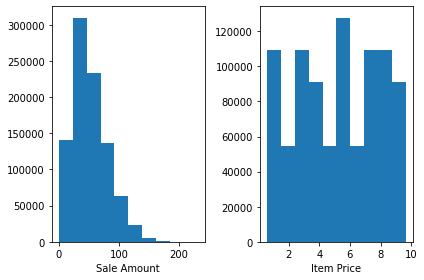

In [3]:
df = prepare.prepare_store_data()

In [228]:
df.head(2)

,item_id,sale_amount,sale_id,store_id,store_address,store_city,store_state,store_zipcode,item_brand,item_name,item_price,item_upc12,item_upc14,day_of_week,month,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,13.0,1,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Tuesday,1,10.92
2013-01-01 00:00:00+00:00,12,26.0,211817,7,12018 Perrin Beitel Rd,San Antonio,TX,78217,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,Tuesday,1,218.40


In [229]:
forecast_df = df[['sale_amount', 'sales_total']].rename(columns = {'sale_amount':'items_sold', 'sales_total':'dollars_sold'})

In [230]:
forecast_df = forecast_df.resample('W').sum()

In [231]:
forecast_df.head(2)

,items_sold,dollars_sold
sale_date,,
2013-01-06 00:00:00+00:00,91067.0,490767.50
2013-01-13 00:00:00+00:00,103902.0,559934.21


In [232]:
train_prop = 0.66
train_size = int(len(forecast_df) * train_prop)
train, test = forecast_df[0:train_size], forecast_df[train_size:len(forecast_df)]

In [233]:
train.shape, test.shape

((172, 2), (89, 2))

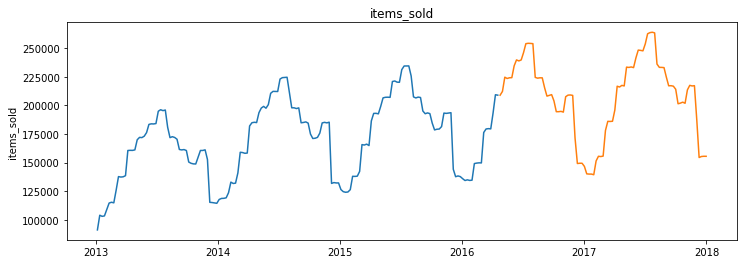

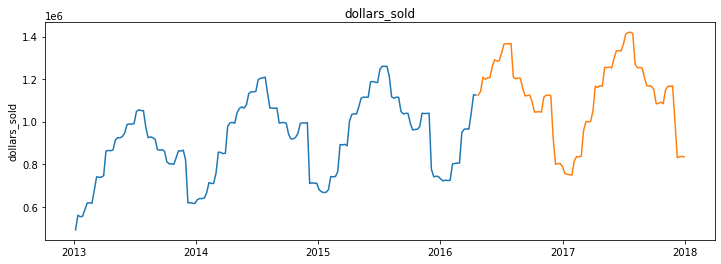

In [234]:
for cols in train.columns:
    plt.figure(figsize = (12,4))
    plt.plot(train[cols])
    plt.plot(test[cols])
    plt.ylabel(cols)
    plt.title(cols)
    plt.show()

In [235]:
def evaluate(target_var):
    mse = metrics.mean_squared_error(test[target_var],yhat_df[target_var])
    rmse = round(math.sqrt(mse),0)
    return rmse

In [236]:
def plot_and_eval(target_var):
    plt.figure(figsize=(12, 4))
    plt.plot(train[target_var],label = 'train')
    plt.plot(test[target_var], label = 'test')
    plt.plot(yhat_df[target_var], label = 'predicted')
    rmse = evaluate(target_var)
    print((target_var, '-- RMSE: {:.0f}'.format(rmse)))
    plt.show()

In [237]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

#### Simple Average

In [238]:
items = round(train['items_sold'].mean(), 0)
dollars = round(train['dollars_sold'].mean(),0)

In [239]:
items, dollars

(169422.0, 910902.0)

In [240]:
yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, index = test.index)

In [241]:
yhat_df.head(2)

,items_sold,dollars_sold
sale_date,,
2016-04-24 00:00:00+00:00,169422.0,910902.0
2016-05-01 00:00:00+00:00,169422.0,910902.0


('items_sold', '-- RMSE: 51876')


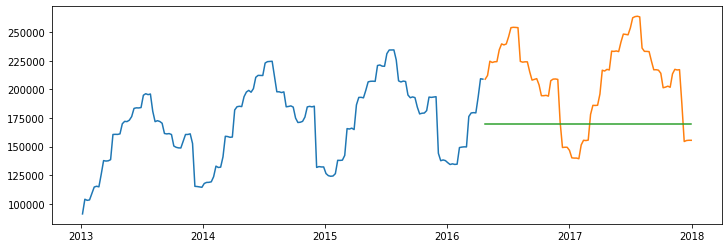

('dollars_sold', '-- RMSE: 278676')


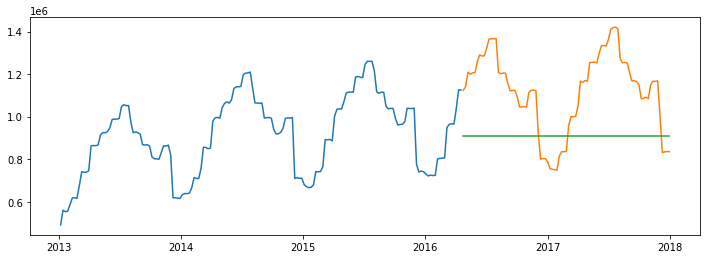

In [244]:
for cols in train.columns:
    plot_and_eval(cols)
    eval_df = append_eval_df(model_type = 'Simple Average', target_var = cols)

#### Moving Average

In [251]:
# lets use 30 day rolling average 
period = 1
items = round(train['items_sold'].rolling(period).mean().iloc[-1],0)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1],0)

In [252]:
items, dollars

(208943.0, 1124579.0)

In [253]:
yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, index = test.index)

In [254]:
yhat_df.head(2)

,items_sold,dollars_sold
sale_date,,
2016-04-24 00:00:00+00:00,208943.0,1124579.0
2016-05-01 00:00:00+00:00,208943.0,1124579.0


('items_sold', '-- RMSE: 34024')


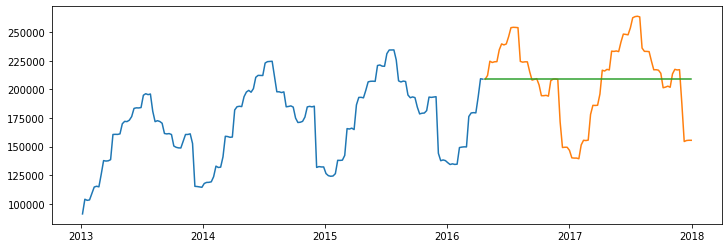

('dollars_sold', '-- RMSE: 182900')


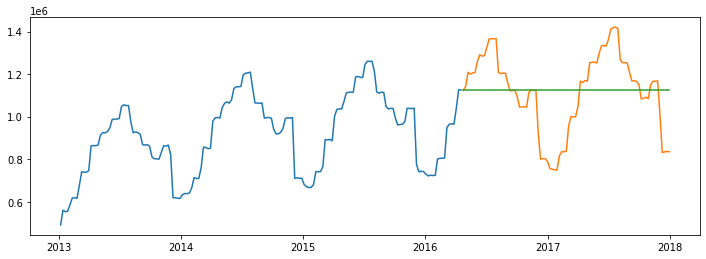

In [255]:
for cols in train.columns:
    plot_and_eval(cols)
    eval_df = append_eval_df(model_type = 'Moving Average', target_var = cols)

1  rolling period(s), rmse =  34024.0
2  rolling period(s), rmse =  34026.0
4  rolling period(s), rmse =  35694.0
8  rolling period(s), rmse =  41674.0
12  rolling period(s), rmse =  50260.0


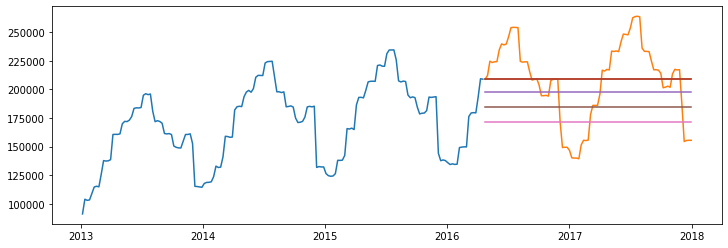

1  rolling period(s), rmse =  182900.0
2  rolling period(s), rmse =  182921.0
4  rolling period(s), rmse =  191718.0
8  rolling period(s), rmse =  223674.0
12  rolling period(s), rmse =  269904.0


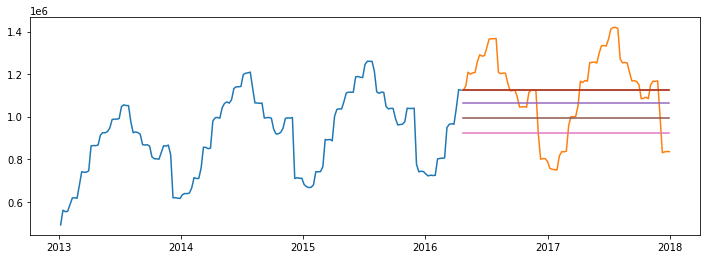

In [256]:
for cols in train.columns:
    
    plt.figure(figsize=(12, 4))
    plt.plot(train[cols],label = 'train')
    plt.plot(test[cols], label = 'test')
    periods = [1, 2,4,8,12]
    for period in periods:
        yhat_df[cols] = train[cols].rolling(period).mean().iloc[-1]
        rmse = evaluate(cols)
        plt.plot(yhat_df[cols])
        print(period, " rolling period(s), rmse = ", evaluate(cols))
    plt.show()

#### Holt's Linear Trend Model

In [257]:
model = Holt(train['items_sold'])
model = model.fit(smoothing_level=.11, smoothing_slope=.1, optimized=False)
yhat_items = model.predict(start = test.index[0], end = test.index[-1] )
yhat_df['items_sold'] = round(yhat_items,0)

In [258]:
model = Holt(train['dollars_sold'])
model = model.fit(smoothing_level=.12, smoothing_slope=.1, optimized=False)
yhat_dollars = model.predict(start = test.index[0], end = test.index[-1])
yhat_df['dollars_sold'] = round(yhat_dollars,0)

('items_sold', '-- RMSE: 48986')


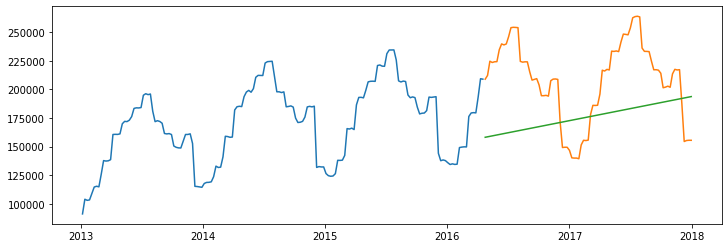

('dollars_sold', '-- RMSE: 231144')


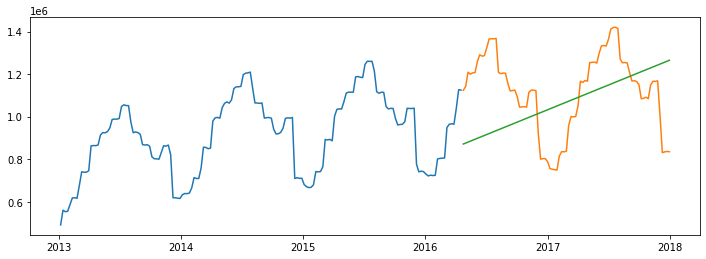

In [260]:
for cols in train.columns:
    plot_and_eval(cols)
    eval_df = append_eval_df(model_type = 'Holt Linear ', target_var = cols)

#### Predict Based on Previous Cycle (year)

In [261]:
forecast_df.head(2)

,items_sold,dollars_sold
sale_date,,
2013-01-06 00:00:00+00:00,91067.0,490767.50
2013-01-13 00:00:00+00:00,103902.0,559934.21


In [262]:
train = forecast_df[:'2016']
test = forecast_df['2017']

In [263]:
train.shape

(208, 2)

In [264]:
test.shape

(53, 2)

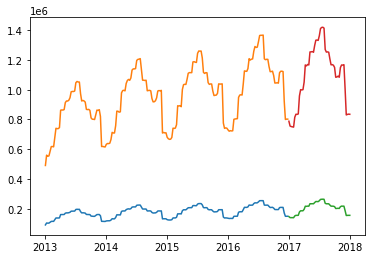

In [265]:
plt.plot(train)
plt.plot(test)

In [268]:
yhat_df = train['2016'] + train.diff(52).mean()

In [269]:
yhat_df.shape, test.shape

((52, 2), (53, 2))

In [270]:
test = test.iloc[0:-1,:]

In [272]:
test.shape

(52, 2)

In [273]:
yhat_df = yhat_df.set_index(test.index)

In [274]:
yhat_df.head(2)

,items_sold,dollars_sold
sale_date,,
2017-01-01 00:00:00+00:00,151225.717949,812371.305705
2017-01-08 00:00:00+00:00,149622.717949,803461.375705


('items_sold', '-- RMSE: 8081')


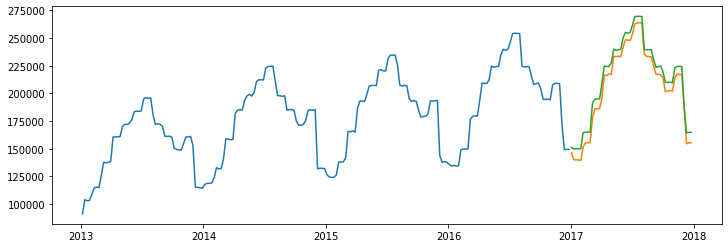

('dollars_sold', '-- RMSE: 43383')


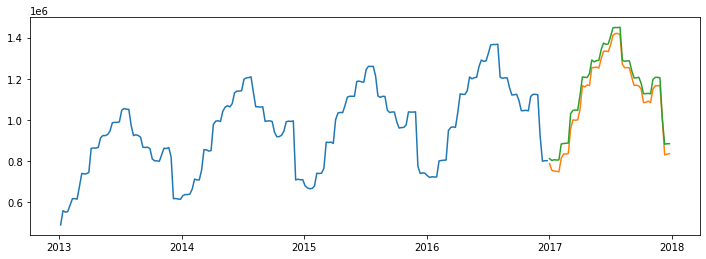

In [275]:
for cols in train.columns:
    plot_and_eval(cols)
    eval_df = append_eval_df(model_type = 'Previous Cycle', target_var = cols)

In [276]:
eval_df

,model_type,target_var,rmse
0,Simple Average,items_sold,51876.0
1,Simple Average,dollars_sold,278676.0
2,Moving Average,items_sold,35694.0
3,Moving Average,dollars_sold,191718.0
4,Moving Average,items_sold,34024.0
5,Moving Average,dollars_sold,182900.0
6,Holt Linear,items_sold,48986.0
7,Holt Linear,dollars_sold,231144.0
8,Previous Cycle,items_sold,8081.0
9,Previous Cycle,dollars_sold,43383.0


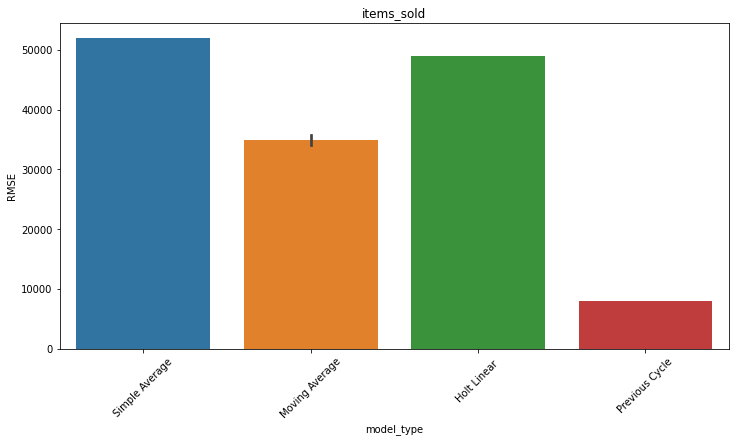

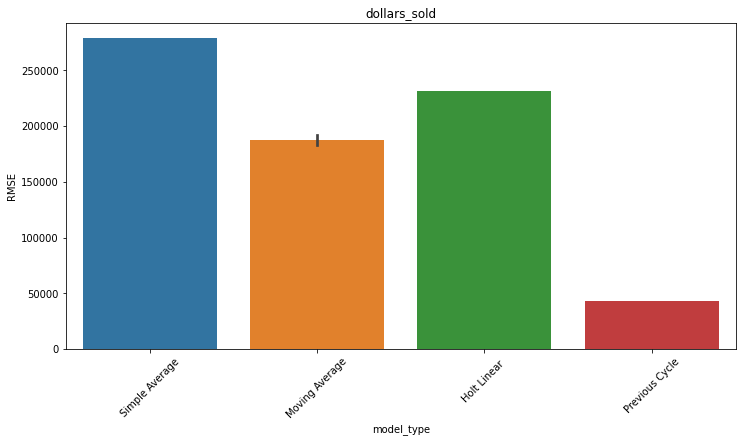

In [277]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()